In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats
import math
pd.options.display.max_rows=200
import seaborn as sns

In [2]:
df_id_result = pd.read_csv('/data/210827_SJH_prosit/210916noPTM/search_result/massIVE-KB_result_noptm.tsv', sep='\t')
df_nid_result = pd.read_csv('/data/210827_SJH_prosit/210916noPTM/search_result/uniprot_result_noptm.tsv', sep='\t')

In [3]:
print(df_id_result.shape)
df_id_result.head(1)

(1165117, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,massIVE-KB_predMS2_frac01_noptm.mgf,index=17911,-1,"17912 File:""massIVE-KB_predMS2_frac17912_noptm...",HCD,915.407,0,0.066675,4,NQSQGYNQWQQGQFWGQKPWSQHYHQGYY,"sp|Q00839|HNRPU_HUMAN(pre=K,post=-);tr|A0A1X7S...",264,264,2.147724e-42,5.912638e-35,0.0,0.0


In [4]:
print(df_nid_result.shape)
df_nid_result.head(1)

(1285166, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,uniprot_predMS2_frac01_noptm.mgf,index=91556,-1,"91557 File:""uniprot_predMS2_frac91557_noptm.mg...",HCD,1791.814,0,0.0,2,NTFWDVDGSMVPPEWHRWLHSMTDDPPTTK,"sp|Q9UI09|NDUAC_HUMAN(pre=K,post=P)",340,340,3.764748e-42,1.041666e-34,0.0,0.0


In [131]:
len(df_nid_result.Peptide.unique())

1259162

* FDR control

In [5]:
def isDecoy(prot):
    prot_cnt = len(prot.split(';'))
    decoy_cnt = 0
    for p in prot.split(';'):
        if 'XXX' in p:
            decoy_cnt += 1
    if decoy_cnt == prot_cnt:
        return 'D'
    else:
        return 'T'

In [6]:
def getFDR(TD_list):
    start = time.time()
    
    FDR_list = []
    T_cnt = 0
    D_cnt = 0
    cut_idx = 0
    
    for idx, label in enumerate(TD_list):
        if label=='T':
            T_cnt += 1
        elif label == 'D':
            D_cnt += 1
        fdr = round((2*D_cnt) / (T_cnt + D_cnt), 2)
        if fdr <= 0.01:
            cut_idx = idx
    return cut_idx

In [7]:
def FDR_control(df, PERCENT):
    df_ = df.sort_values('EValue').reset_index(drop=True)  # copy
    df_['TD_label'] = df_.Protein.apply(isDecoy).values
    print('********** Target Decoy Labelling Done **********')
    cut_idx = getFDR(df_.TD_label.values)  
    print('********** Calculating FDR Done **********')
    df_ = df_.iloc[:cut_idx+1].reset_index(drop=True)
    df_ = df_.loc[df_.TD_label=='T'].reset_index(drop=True)
    return df_

In [8]:
df_id_target = FDR_control(df_id_result, 0.01)
df_nid_target = FDR_control(df_nid_result, 0.01)

print('massIVE-KB Evalue max, min : ', max(df_id_target.SpecEValue.values), min(df_id_target.SpecEValue.values))  # maaIVE-KB
print('uniprot Evalue max, min : ', max(df_nid_target.SpecEValue.values), min(df_nid_target.SpecEValue.values))  # uniprot

print('massIVE-KB Evalue max, min : ', max(df_id_target.EValue.values), min(df_id_target.EValue.values))  # maaIVE-KB
print('uniprot Evalue max, min : ', max(df_nid_target.EValue.values), min(df_nid_target.EValue.values))  # uniprot

********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********
********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********
massIVE-KB Evalue max, min :  3.6722186e-06 2.1477244403011e-42
uniprot Evalue max, min :  6.2978023e-09 1.4942184623296585e-44
massIVE-KB Evalue max, min :  96.76771 5.912637919438798e-35
uniprot Evalue max, min :  0.14632124 4.1343436498436185e-37


* decoy protien identificatin count

In [9]:
from matplotlib_venn import venn2, venn2_circles

nonDetection Peptide set : 2338
intersection cnt : 66
Detection Peptide set : 569
whole cnt : 2841



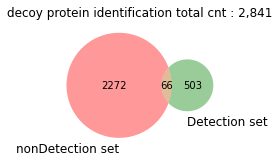

In [10]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('decoy protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

In [11]:
df_id_target_removeDecoy = df_id_target.copy()
df_nid_target_removeDecoy = df_nid_target.copy()

p = []
for prot in df_id_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_id_target_removeDecoy['Protein'] = p
df_id_target_removeDecoy = df_id_target_removeDecoy.loc[df_id_target_removeDecoy.Protein!='']
p = []
for prot in df_nid_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_nid_target_removeDecoy['Protein'] = p
df_nid_target_removeDecoy = df_nid_target_removeDecoy.loc[df_nid_target_removeDecoy.Protein!='']

In [12]:
unique_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_id_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_id_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_id_target_removeDecoy.Protein.values for __ in _.split(';')}

print("총 PSM 수 :", len(df_id_target_removeDecoy))
print("펩타이드 수 :", len(df_id_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

unique_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_nid_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_nid_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_nid_target_removeDecoy.Protein.values for __ in _.split(';')}

print("\n총 PSM 수 :", len(df_nid_target_removeDecoy))
print("펩타이드 수 :", len(df_nid_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

총 PSM 수 : 1164488
펩타이드 수 : 824043
Unique 펩타이드 수 : 354578
Shared 펩타이드 수 : 469465
단백질 수 : 65398

총 PSM 수 : 930814
펩타이드 수 : 926520
Unique 펩타이드 수 : 437270
Shared 펩타이드 수 : 489250
단백질 수 : 65139


* Protein identification count

In [13]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' not in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' not in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

nonDetection Peptide set : 65139
intersection cnt : 62110
Detection Peptide set : 65398
whole cnt : 68427



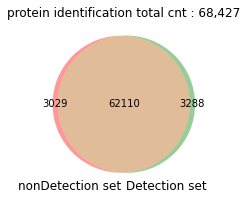

In [14]:
plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

* Peptide idenfication count

In [15]:
id_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_precursors),
         len(nid_precursors.intersection(id_precursors)),
         len(id_precursors),
         len(nid_precursors.union(id_precursors))))

nonDetection Peptide set : 897,783
intersection cnt : 677
Detection Peptide set : 1,164,085
whole cnt : 2,061,191



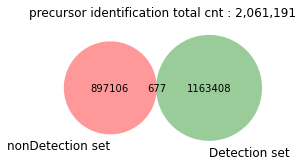

In [16]:
plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_precursors, id_precursors], set_labels=('nonDetection set', 'Detection set'))
plt.title('precursor identification total cnt : {:,}'.format(len(nid_precursors.union(id_precursors))))
plt.show()

nonDetection Peptide set : 897,783
intersection cnt : 943
Detection Peptide set : 823,957
whole cnt : 1,720,797



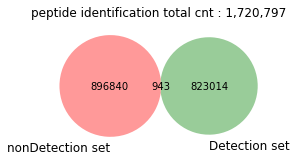

In [17]:
id_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_peptides),
         len(nid_peptides.intersection(id_peptides)),
         len(id_peptides),
         len(nid_peptides.union(id_peptides))))

plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_peptides, id_peptides], set_labels=('nonDetection set', 'Detection set'))
plt.title('peptide identification total cnt : {:,}'.format(len(nid_peptides.union(id_peptides))))
plt.show()

* MSGFscore violin plot

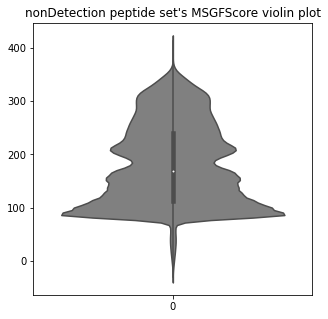

In [18]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_nid_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('nonDetection peptide set\'s MSGFScore violin plot')
plt.show()

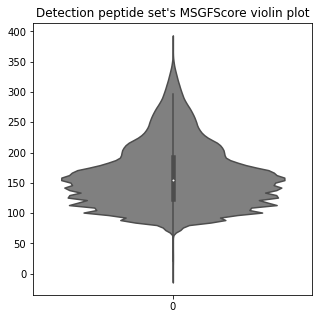

In [19]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_id_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('Detection peptide set\'s MSGFScore violin plot')
plt.show()

In [20]:
df_nonid = pd.DataFrame([[_, 'nonID', 'score'] for _ in df_nid_target_removeDecoy.MSGFScore.values],
                        columns=['MSGFScore', 'label', 'score'])
df_id = pd.DataFrame([[_, 'ID', 'score'] for _ in df_id_target_removeDecoy.MSGFScore.values],
                     columns=['MSGFScore', 'label', 'score'])

df_MSGFScore = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

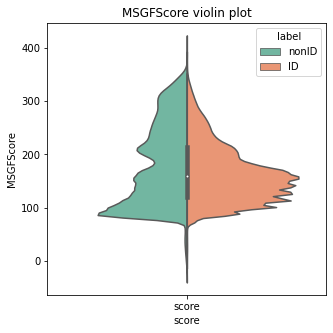

In [21]:
plt.figure(figsize=(5,5))
sns.violinplot(x='score', y="MSGFScore", hue="label",
                    data=df_MSGFScore, 
                    palette="Set2",
                    split=True,
                    scale="count"
                   )
plt.title('MSGFScore violin plot')
plt.show()

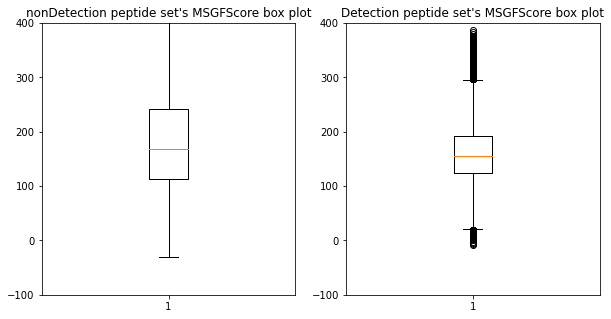

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
ax[0].boxplot(df_nid_target_removeDecoy.MSGFScore.values)
ax[1].boxplot(df_id_target_removeDecoy.MSGFScore.values)

ax[0].set_ylim(-100, 400)
ax[1].set_ylim(-100, 400)
ax[0].set_title('nonDetection peptide set\'s MSGFScore box plot')
ax[1].set_title('Detection peptide set\'s MSGFScore box plot')

plt.show()

# 2d plotting

In [72]:
%matplotlib inline

In [73]:
df_id_2d = pd.DataFrame([[len(p), m, 'ID', 'score'] for p, m in df_id_target[['Peptide', 'MSGFScore']].values],
                        columns=['PeptideLength', 'MSGFScore', 'Label', 'score'])
df_nonid_2d = pd.DataFrame([[len(p), m, 'nonID', 'score'] for p, m in df_nid_target[['Peptide', 'MSGFScore']].values],
                        columns=['PeptideLength', 'MSGFScore', 'Label', 'score'])

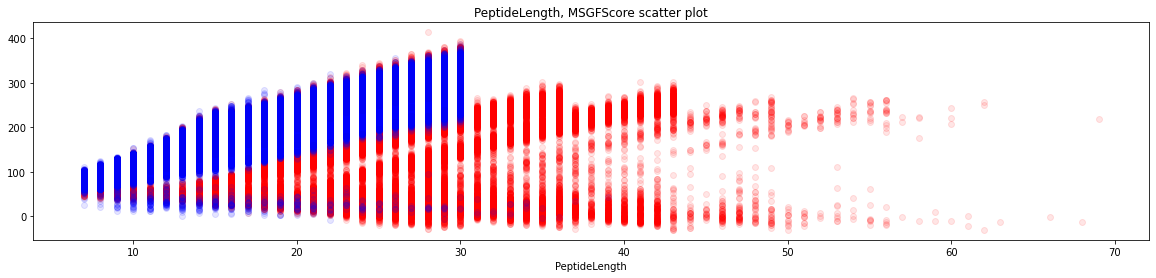

In [74]:
plt.figure(figsize=(20,4))

p = df_nonid_2d.sort_values('PeptideLength').PeptideLength.values
m = df_nonid_2d.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='red', label='nonID')

p = df_id_2d.sort_values('PeptideLength').PeptideLength.values
m = df_id_2d.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='blue', label='ID')

plt.title('PeptideLength, MSGFScore scatter plot')
plt.xlabel('PeptideLength')
plt.show()

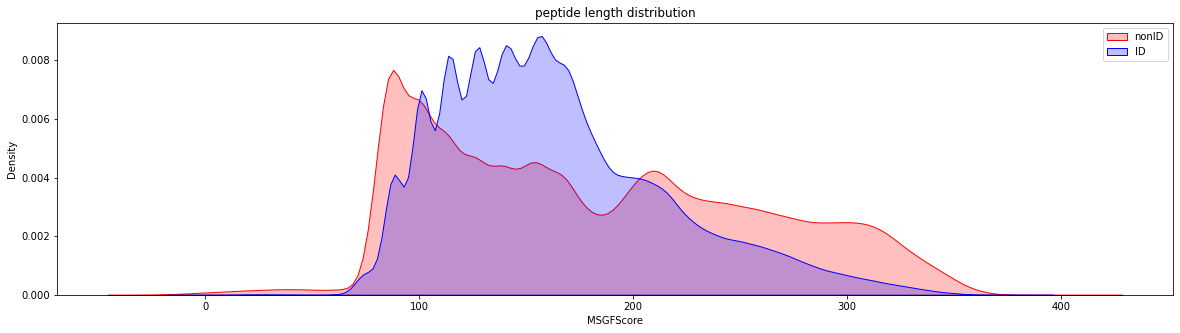

In [75]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d.MSGFScore, shade=True, color='red')

sns.kdeplot(df_id_2d.MSGFScore, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('peptide length distribution')
plt.show()

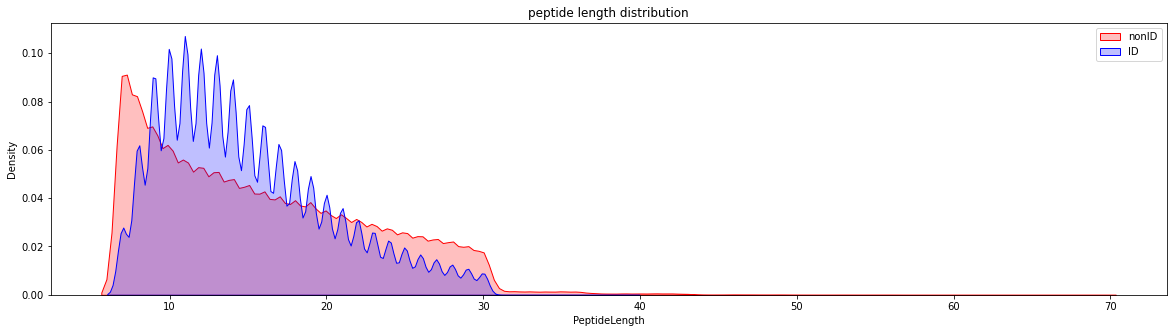

In [76]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d.PeptideLength, shade=True, color='red')

sns.kdeplot(df_id_2d.PeptideLength, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('peptide length distribution')
plt.show()

# 3d plotting

In [77]:
print('id min max : ', min(df_id_2d.MSGFScore.values), max(df_id_2d.MSGFScore.values), 
      '\nnid min max : ', min(df_nonid_2d.MSGFScore.values), max(df_nonid_2d.MSGFScore.values))
max_val = max(max(df_id_2d.MSGFScore.values), max(df_nonid_2d.MSGFScore.values))
min_val = min(min(df_id_2d.MSGFScore.values), min(df_nonid_2d.MSGFScore.values))

id min max :  -8 387 
nid min max :  -31 414


In [78]:
lenscore2freq = dict()
for p, m in df_id_2d[['PeptideLength', 'MSGFScore']].values:
    if p <= 30:  # only use under peptide length 30
        if (p,m) not in lenscore2freq:
            lenscore2freq[(p,m)]=0
        lenscore2freq[(p, m)] += 1
df_id_3d = pd.DataFrame([[p, m, f, 'ID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

lenscore2freq = dict()
for p, m in df_nonid_2d[['PeptideLength', 'MSGFScore']].values:
    if p <= 30:
        if (p,m) not in lenscore2freq:
            lenscore2freq[(p,m)]=0
        lenscore2freq[(p, m)] += 1
df_nonid_3d = pd.DataFrame([[p, m, f, 'nonID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

In [79]:
%matplotlib notebook

<IPython.core.display.Javascript object>


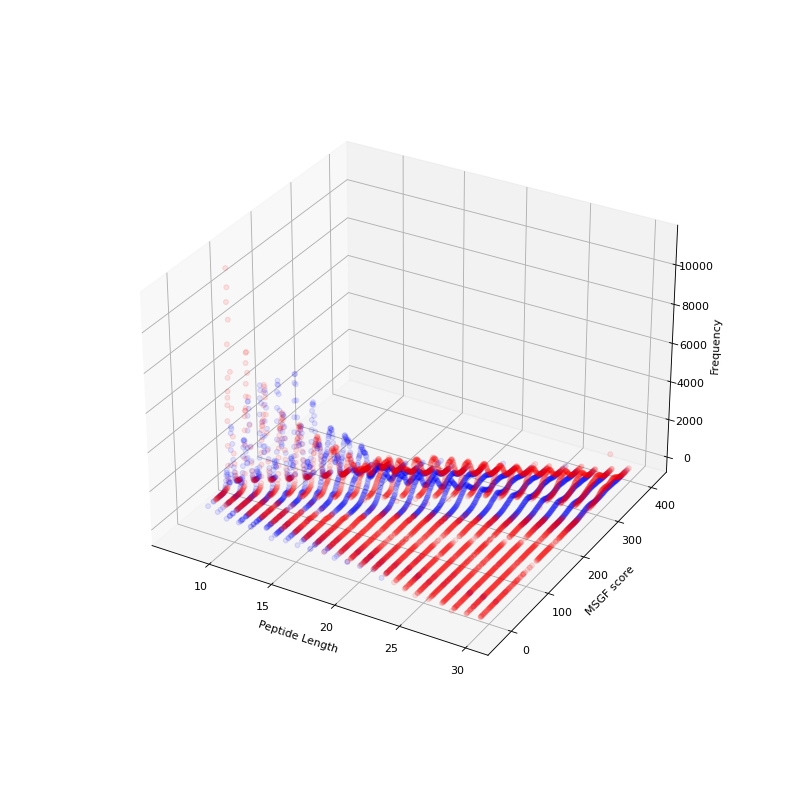

In [80]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d.PeptideLength.values
y = df_nonid_3d.MSGFScore.values
z = df_nonid_3d.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d.PeptideLength.values
y2 = df_id_3d.MSGFScore.values
z2 = df_id_3d.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

<IPython.core.display.Javascript object>


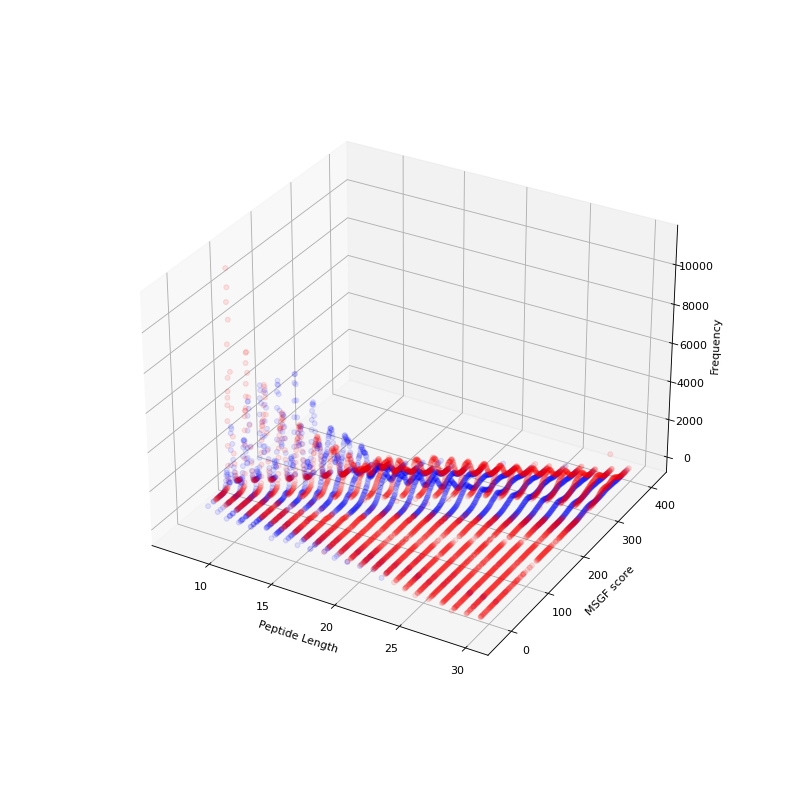

In [81]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d.PeptideLength.values
y = df_nonid_3d.MSGFScore.values
z = df_nonid_3d.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d.PeptideLength.values
y2 = df_id_3d.MSGFScore.values
z2 = df_id_3d.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

In [82]:
df_id_3d_cut = df_id_3d.loc[df_id_3d.Frequency<=4000]
df_nonid_3d_cut = df_nonid_3d.loc[df_nonid_3d.Frequency<=4000]

<IPython.core.display.Javascript object>


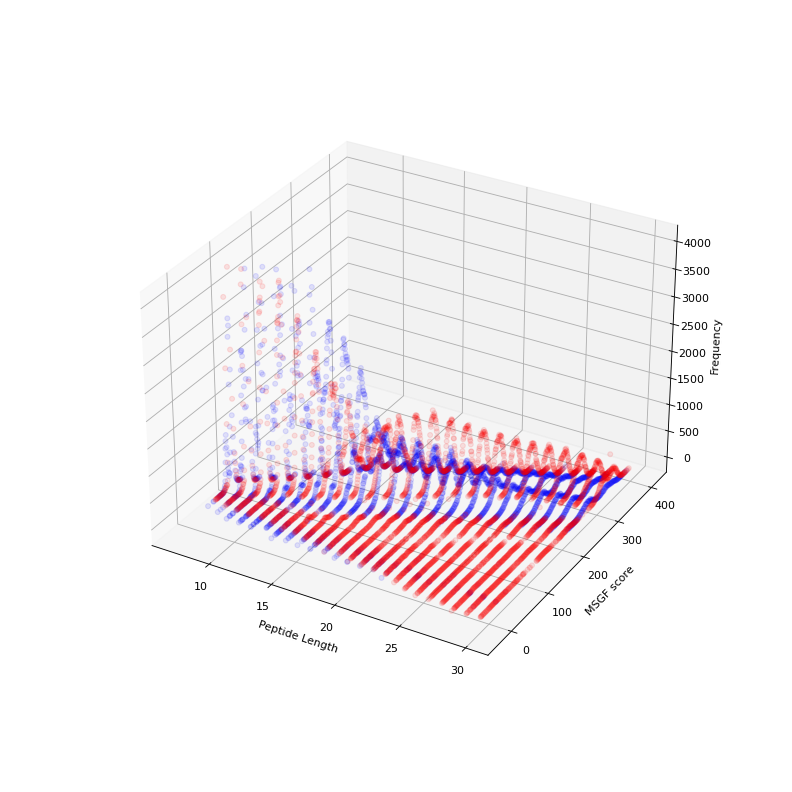

In [83]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_cut.PeptideLength.values
y = df_nonid_3d_cut.MSGFScore.values
z = df_nonid_3d_cut.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_cut.PeptideLength.values
y2 = df_id_3d_cut.MSGFScore.values
z2 = df_id_3d_cut.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

# not FDR (whole PSM plotting)

# 2d plotting

In [85]:
%matplotlib inline

In [86]:
df_id_result['TD'] = df_id_result.Protein.apply(isDecoy).values
df_nid_result['TD'] = df_nid_result.Protein.apply(isDecoy).values

df_id_target_whole = df_id_result.loc[df_id_result.TD=='T'].reset_index(drop=True)
df_nid_target_whole = df_nid_result.loc[df_nid_result.TD=='T'].reset_index(drop=True)

In [87]:
df_id_2d_nofdr = pd.DataFrame([[len(p), m, se, e, 'ID', 'score'] 
                               for p, m, se, e in df_id_target_whole[['Peptide', 'MSGFScore', 'SpecEValue', 'EValue']].values],
                        columns=['PeptideLength', 'MSGFScore', 'SpecEValue', 'EValue', 'Label', 'score'])
df_nonid_2d_nofdr = pd.DataFrame([[len(p), m, se, e, 'nonID', 'score'] 
                               for p, m, se, e in df_nid_target_whole[['Peptide', 'MSGFScore', 'SpecEValue', 'EValue']].values],
                        columns=['PeptideLength', 'MSGFScore', 'SpecEValue', 'EValue', 'Label', 'score'])

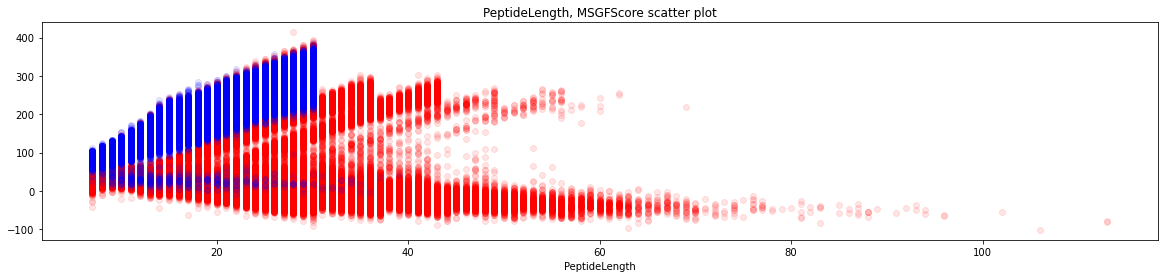

In [47]:
plt.figure(figsize=(20,4))

p = df_nonid_2d_nofdr.sort_values('PeptideLength').PeptideLength.values
m = df_nonid_2d_nofdr.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='red', label='nonID')

p = df_id_2d_nofdr.sort_values('PeptideLength').PeptideLength.values
m = df_id_2d_nofdr.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='blue', label='ID')

plt.title('PeptideLength, MSGFScore scatter plot')
plt.xlabel('PeptideLength')
plt.show()

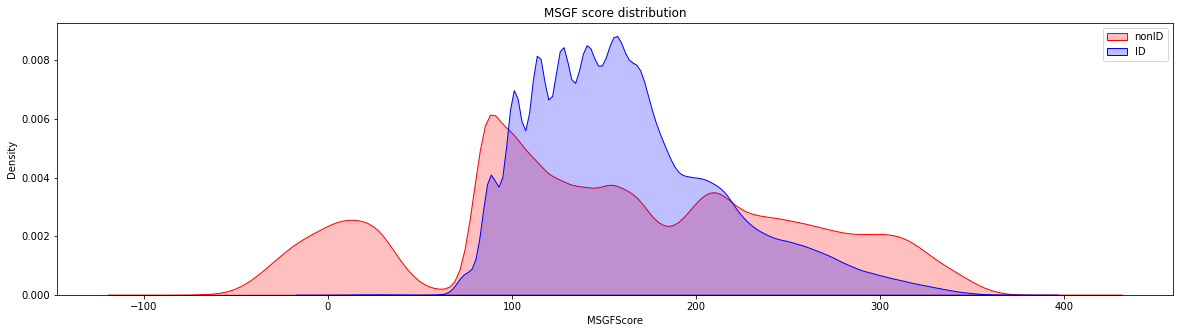

In [48]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.MSGFScore, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.MSGFScore, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('MSGF score distribution')
plt.show()

* get zero unDetected peptide

In [105]:
t = sorted(list(filter(lambda x: x<=80, df_nid_target_whole.MSGFScore)), reverse=True)
d = dict()
for _ in t:
    if _ not in d:
        d[_]=0
    d[_]+=1

d

{80: 4483,
 79: 3679,
 78: 2362,
 77: 1341,
 76: 629,
 75: 307,
 74: 220,
 73: 184,
 72: 222,
 71: 152,
 70: 160,
 69: 157,
 68: 149,
 67: 169,
 66: 191,
 65: 206,
 64: 194,
 63: 208,
 62: 198,
 61: 176,
 60: 193,
 59: 187,
 58: 200,
 57: 210,
 56: 226,
 55: 244,
 54: 242,
 53: 258,
 52: 330,
 51: 355,
 50: 430,
 49: 454,
 48: 522,
 47: 579,
 46: 659,
 45: 691,
 44: 847,
 43: 918,
 42: 916,
 41: 1135,
 40: 1211,
 39: 1295,
 38: 1410,
 37: 1455,
 36: 1571,
 35: 1664,
 34: 1868,
 33: 1975,
 32: 2087,
 31: 2190,
 30: 2368,
 29: 2452,
 28: 2620,
 27: 2725,
 26: 2639,
 25: 2739,
 24: 2781,
 23: 2658,
 22: 2791,
 21: 2807,
 20: 2849,
 19: 2834,
 18: 2763,
 17: 2784,
 16: 2931,
 15: 2851,
 14: 2937,
 13: 2791,
 12: 2953,
 11: 2896,
 10: 2820,
 9: 2798,
 8: 2975,
 7: 2905,
 6: 2816,
 5: 2795,
 4: 2755,
 3: 2783,
 2: 2743,
 1: 2667,
 0: 2579,
 -1: 2572,
 -2: 2565,
 -3: 2513,
 -4: 2472,
 -5: 2441,
 -6: 2312,
 -7: 2353,
 -8: 2419,
 -9: 2244,
 -10: 2261,
 -11: 2242,
 -12: 2185,
 -13: 2185,
 -14: 2

In [107]:
df_zero = df_nid_target_whole.loc[df_nid_target_whole.MSGFScore<=68]

In [110]:
pep_ptm = set()
pep_noptm = set()
for p in df_zero.Peptide.values:
    if '+' in p:
        pep_ptm.add(p)
    else:
        pep_noptm.add(p)

pep_zero = df_zero.Peptide.unique()

In [128]:
print('total zero MSGF score peptides : {:,}'.format(len(pep_zero)))
print('zero MSGF score ptm_peptides : {:,}'.format(len(pep_ptm)))
print('zero MSGF score noptm_peptides : {:,}'.format(len(pep_noptm)))

total zero MSGF score peptides : 183,012
zero MSGF score ptm_peptides : 89,470
zero MSGF score noptm_peptides : 93,542


In [135]:
import pickle
with open('pep_zeroMSGF_noptm.pickle', 'wb') as f:
    pickle.dump(pep_noptm, f, pickle.HIGHEST_PROTOCOL)

# with open('pep_zeroMSGF_noptm.pickle', 'rb') as f:
#     t = pickle.load(f)

* 실제 정답과 Target이 얼마나 교집합인지 확인

In [122]:
df_nid_real = pd.read_csv('../data/uniprot/df_whole_pep_from_prot_noptm.csv')
df_id_real = pd.read_csv('../data/massIVE-KB/df_kb_noptm.csv')

id_pep = set(df_id_real.PEPTIDE.unique())
nid_pep = set(df_nid_real.loc[df_nid_real.ID==0].PEP.unique())

nid_pep_pred = set(df_nid_target_whole.Peptide.unique())
id_pep_pred = set(df_id_target_whole.Peptide.unique())

In [124]:
id_common = id_pep.intersection(id_pep_pred)
nid_common = nid_pep.intersection(nid_pep_pred)
print('id correct / whole_target:{:,} / {:,}\nnid correct / whole_target:{:,} / {:,}'.format(
    len(id_common), len(id_pep_pred), len(nid_common), len(nid_pep_pred)))

id correct / whole_target:823,038 / 824,043
nid correct / whole_target:897,192 / 1,084,942


In [130]:
incorrect_nid_pred = nid_pep_pred.difference(nid_pep)
incorrect_zeroMSGF_common = incorrect_nid_pred.intersection(pep_zero)
print('zero MSGF score peptide INTERSECTION incorrect nid peptides : {:,}'.format(len(incorrect_zeroMSGF_common)))

zero MSGF score peptide INTERSECTION incorrect nid peptides : 165,773


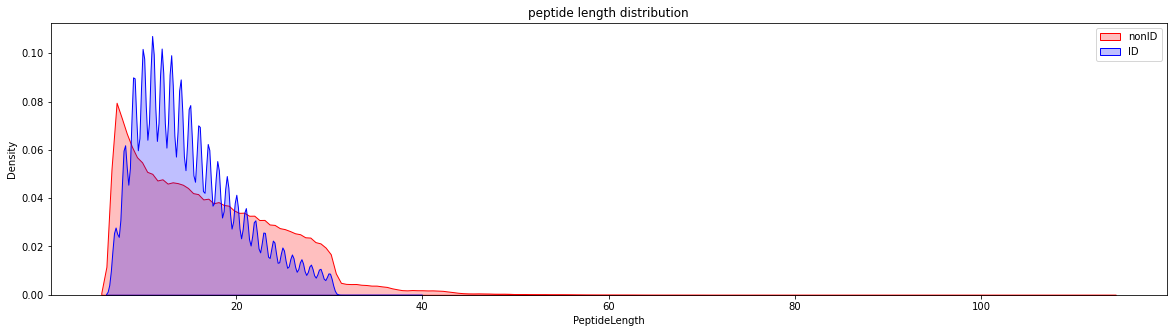

In [49]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.PeptideLength, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.PeptideLength, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('peptide length distribution')
plt.show()

In [50]:
# Evalue score

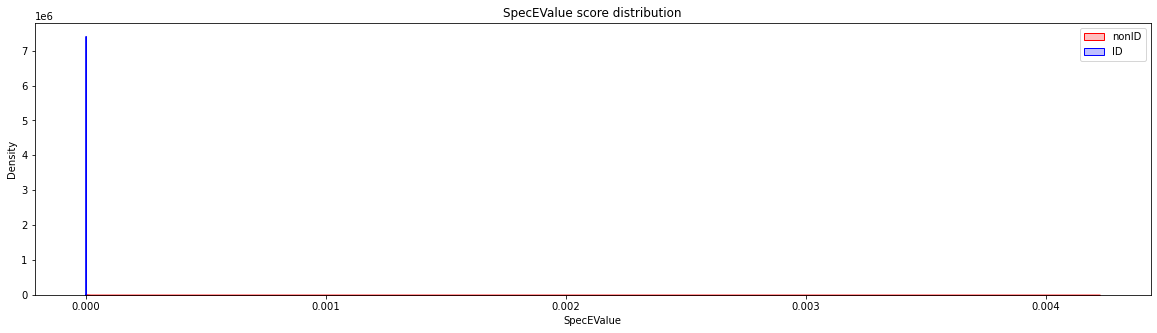

In [59]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.SpecEValue, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.SpecEValue, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('SpecEValue score distribution')
plt.show()

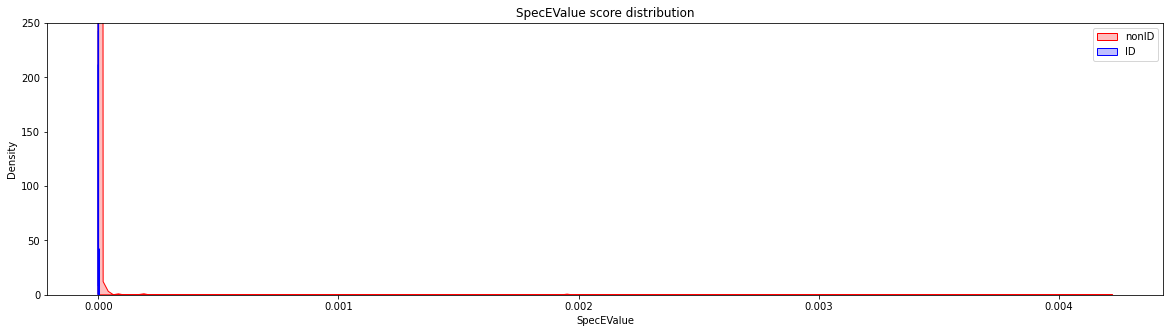

In [60]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.SpecEValue, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.SpecEValue, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('SpecEValue score distribution')
plt.ylim(0, 250)
plt.show()

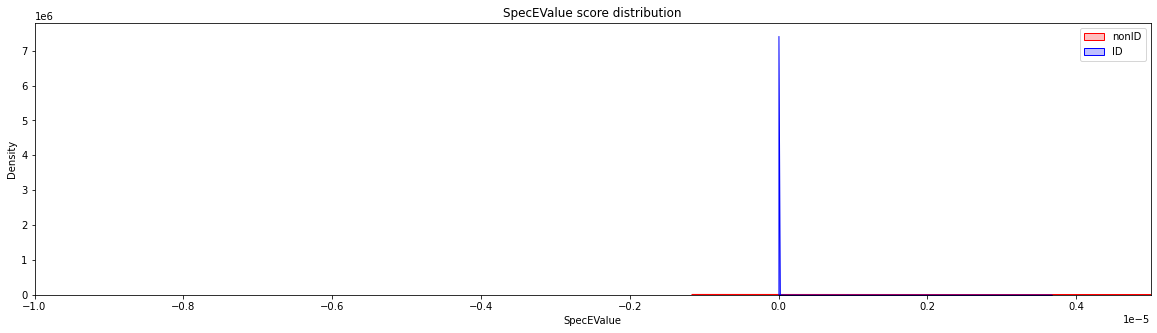

In [145]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.SpecEValue, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.SpecEValue, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('SpecEValue score distribution')
plt.xlim(-0.00001, 0.000005)
plt.show()

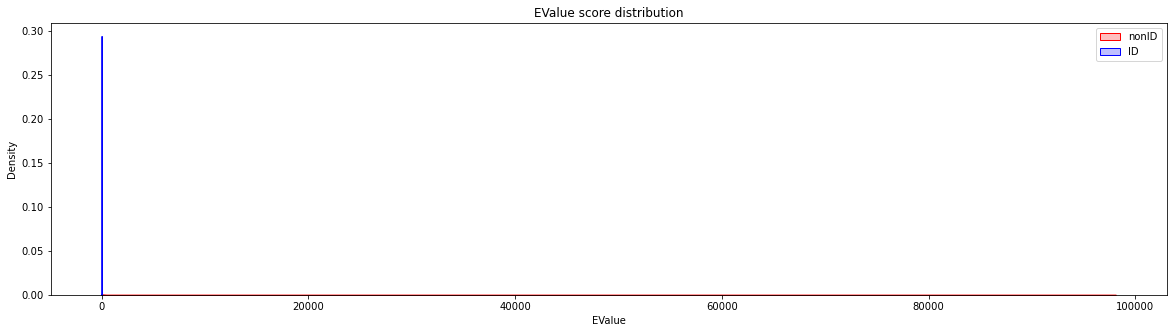

In [61]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.EValue, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.EValue, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('EValue score distribution')
plt.show()

# 3d plotting

In [62]:
print('id min max : ', min(df_id_2d_nofdr.MSGFScore.values), max(df_id_2d_nofdr.MSGFScore.values), 
      '\nnid min max : ', min(df_nonid_2d_nofdr.MSGFScore.values), max(df_nonid_2d_nofdr.MSGFScore.values))
max_val = max(max(df_id_2d_nofdr.MSGFScore.values), max(df_nonid_2d_nofdr.MSGFScore.values))
min_val = min(min(df_id_2d_nofdr.MSGFScore.values), min(df_nonid_2d_nofdr.MSGFScore.values))

id min max :  -8 387 
nid min max :  -102 414


In [63]:
lenscore2freq = dict()
for p, m in df_id_2d_nofdr[['PeptideLength', 'MSGFScore']].values:
    if p <= 30:  # only use under peptide length 30
        if (p,m) not in lenscore2freq:
            lenscore2freq[(p,m)]=0
        lenscore2freq[(p, m)] += 1
df_id_3d_nofdr = pd.DataFrame([[p, m, f, 'ID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

lenscore2freq = dict()
for p, m in df_nonid_2d_nofdr[['PeptideLength', 'MSGFScore']].values:
    if p <= 30:
        if (p,m) not in lenscore2freq:
            lenscore2freq[(p,m)]=0
        lenscore2freq[(p, m)] += 1
df_nonid_3d_nofdr = pd.DataFrame([[p, m, f, 'nonID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

In [64]:
%matplotlib notebook

<IPython.core.display.Javascript object>


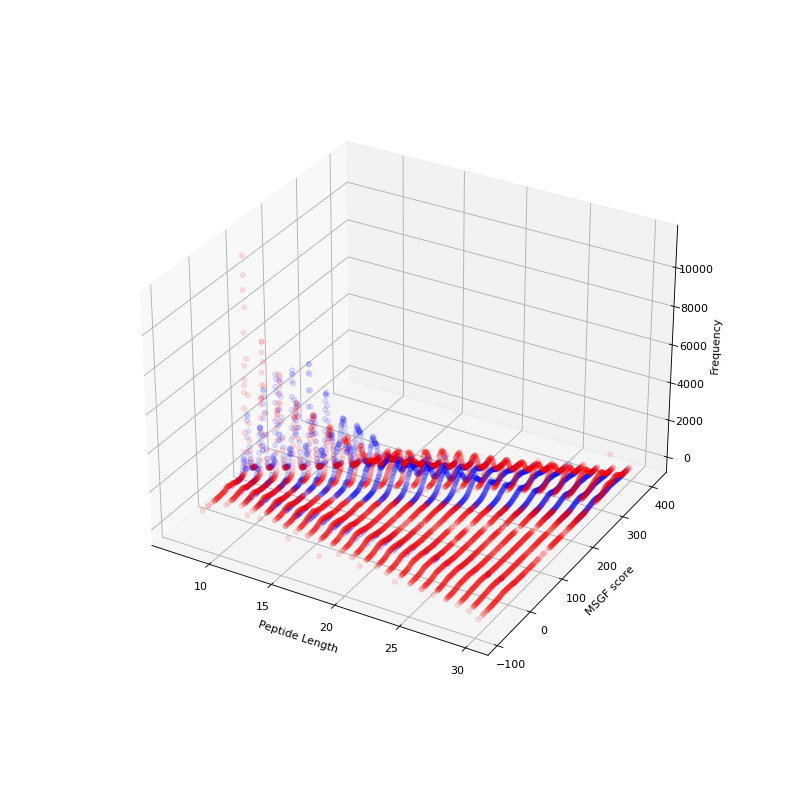

In [65]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_nofdr.PeptideLength.values
y = df_nonid_3d_nofdr.MSGFScore.values
z = df_nonid_3d_nofdr.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_nofdr.PeptideLength.values
y2 = df_id_3d_nofdr.MSGFScore.values
z2 = df_id_3d_nofdr.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

In [66]:
df_id_3d_nofdr_cut = df_id_3d_nofdr.loc[df_id_3d_nofdr.Frequency<=4000]
df_nonid_3d_nofdr_cut = df_nonid_3d_nofdr.loc[df_nonid_3d_nofdr.Frequency<=4000]

<IPython.core.display.Javascript object>


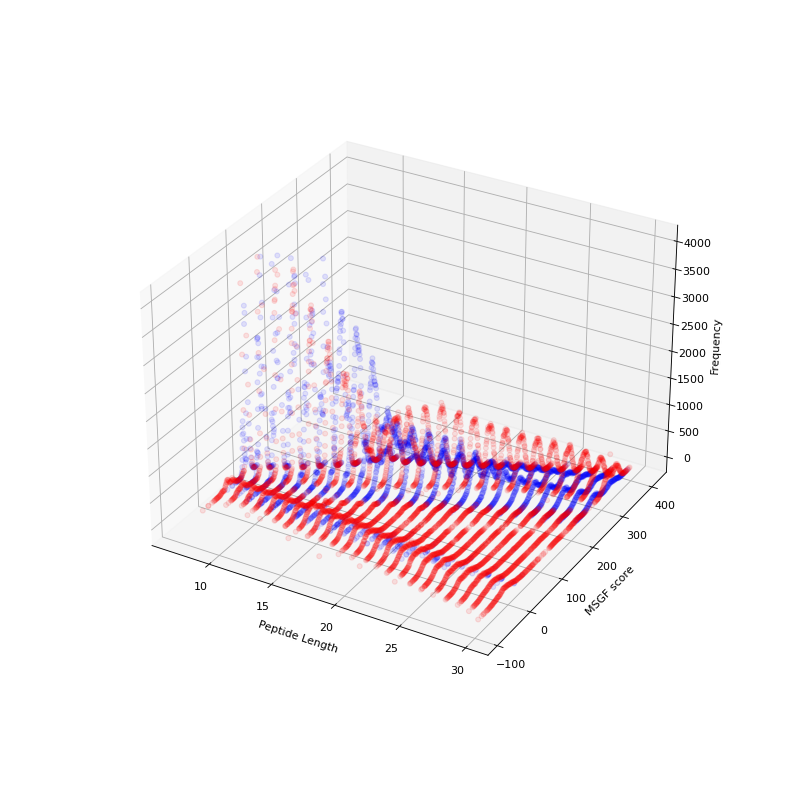

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_nofdr_cut.PeptideLength.values
y = df_nonid_3d_nofdr_cut.MSGFScore.values
z = df_nonid_3d_nofdr_cut.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_nofdr_cut.PeptideLength.values
y2 = df_id_3d_nofdr_cut.MSGFScore.values
z2 = df_id_3d_nofdr_cut.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()